## Prediction of longline fishing activity

**SUMMARY OF STRATEGY**

For this analysis, a large part of my time was directed toward understanding and processing the data. My research of longline fishing was to obtain some intuition how the features I was given could provide information to a model, if some sort of transformation may be required, and if there were other features not included in the given data set that would be useful. 

**Sample data:** There is nearly twice the number of positive samples than negative samples. To reduce bias toward the over-represented class, random oversampling of negative samples was performed to balance the data. Alternatively, I could have used random undersampling of positive samples. There were no null values in the data, but if there was then I would have imputed the missing data with a method depending on the data type.

**Features:** There are initally 12 features and I separated the unix datetime variable into individual features: year, month, day, hour, and mintue. The data are time-dependent (but not a time series since data points are not equal intervals of time) since samples are related to other samples with the same mmsi value, i.e. same vessel. Therefore, I attempted to generate additional features that caputre relationships between samples based on my understanding of how longline fishing vessels operate. A list of these features to generate is discussed below. For example, I attempted to create a new feature that gives the average of 'is_fishing' scores for other vessels within 1000m for a given day. The idea is that a vessel in close proximity to an actively fishing vessel is also likely fishing. The code for generating this feature did not quite work, and with limited time and the code being computationally expensive I ran out of time to troubleshoot. This task would be future work.

**Feature selection:** I removed features exhibiting colinearity (e.g. distance_to_port and distance_to_shore).

**Modeling:** 
*Rationale*: I chose three standard algorithms for classification – logistic regression, linear discrimiant analysis (LDA), SVM, and decision tree – to build a classifier. Logisitic regression and LDA are similar in the sense that they model the conditional distributions, where logistic regression models the distributin of the response variabel 'is_fishing' and LDA models the conditinal distribution of the features. When the distributions of features is normal, LDA looks a lot like logistic regression. However, I included both methods in this analysis because LDA is more stable than logistic regression when, as in our case, the sample size is small. A tree-based method was included as a comparison to logistic regression and LDA models. Together, these methods represent different algroithms, make different assumptions, employ different methods of estimation (e.g. maximum likelihood estimation vs. least squares estimation), and have different bias/vairance trade-off (e.g. decision trees are prone to over-fitting/high bias). 


**Results:** I intially built models using default settings and without optimizing hyperparameters (such as C for regularization). Model performance was compared using accuracy and AUC-ROC score, to understand how close the model predicts the true value and the distinction between true positives and true negatives, respectively. These baseline models showed that logistic regression and LDA indeed performed similarly with high accuray (93%) but an AUC-ROC score of 0.5, which is equivalent to random chance. The SVM model performed poorly, no better than random chance with an AUC-ROC value of 0.5. This score can be explained by viewing true/false positive and negative counts: logistic regression, LDA, and SVM models predicted all test samples as not fishing, i.e. 'is_fishing' == 0. The decision tree model correctly predicts some vessels as fishing, but incorrectly predicts more vessels as fishing, hence the low accuracy (40%). However the AUC-ROC value is 0.6072, which is still not a favorable performance but better than the other models.


**FUTURE WORK**

1. Optimize 'is_fishing' cut-off: I arbitraily considered vessels as not fishing for scores between [0,0.5) fishing for scores between [0.5,1]. These values could be optimized. Knowing the standard deviation of this average score would help to inform how confident we are in the score and how conseravative to make our cut-off.

2. Perform further feature selection: I would examine the p-values for all the features in the four models and remove features that are not significant.
 
3. Generate more features: I discuss some features that could be generated from the data set or potentially sought from publicly available historic data sets. The latter includes sea surface temperature (SST), sea bed topography, current charts, temperature break data that would be cross-referenced by date/time and longitude/latitude coordinates. I would then retrain the models on this expaned feature data set.
 
4. Optimize the decision tree model by using cross-validation during training, implement pruning to reduce model complexity (reduce bias), and include cut-offs for the number of samples that are required in each leaf.

5. Build a time series model using LSTM: For future work, I would explore training a LSTM on the data set strucutred as a time sereis. With the vessel ID (‘mmsi’) included as a feature, the neural network will learn from all of the data and potentially learn unique charateristics of each vessel. I would look to employ tranfer learning, if such a LSTM model already exists and is avaialbe. Whether using transfering learning or building a LSTM model from scratch, I would optimize for the window (lag) size, i.e. how many time points behind the network remembers. LSTM is good for remembering relatively short sequences, and if it’s not suitable for this data set then I would try other types of RNNs.

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt


### Data processing

In [2]:
# Load and view the Automatic Identify System (AIS) data for longline vessels

longline_data = pd.read_csv('longline_data.csv',index_col=0)
longline_data['mmsi'] = longline_data['mmsi'].astype(int)

# Convert UNIX timestamp to date-time
longline_data['timestamp'] = pd.to_datetime(longline_data['timestamp'],unit='s')
longline_data['year'] = longline_data['timestamp'].dt.year
longline_data['month'] = longline_data['timestamp'].dt.month
longline_data['day'] = longline_data['timestamp'].dt.day
longline_data['hour'] = longline_data['timestamp'].dt.hour
longline_data['minute'] = longline_data['timestamp'].dt.minute

# Drop timestamp (not compatible for regression modeling)
longline = longline_data.drop('timestamp', axis=1)
longline.head()

/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,mmsi,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,year,month,day,hour,minute
index,,,,,,,,,,,,,
0,12639600000000,232994.2813,311748.6563,8.2,230.500000,14.865583,-26.853662,-1,2012,1,21,9,1
1,12639600000000,232994.2813,311748.6563,8.2,230.500000,14.865583,-26.853662,-1,2012,1,21,9,1
2,12639600000000,233994.2656,312410.3438,7.3,238.399994,14.863870,-26.856800,-1,2012,1,21,9,3
3,12639600000000,233994.2656,312410.3438,7.3,238.399994,14.863870,-26.856800,-1,2012,1,21,9,3
4,12639600000000,233994.2656,312410.3438,6.8,238.899994,14.861551,-26.860649,-1,2012,1,21,9,5


In [3]:
cols = longline.columns.tolist()
# cols

**AIS data**: The following data is provided with AIS data (downloaded [here](https://globalfishingwatch.org/data-download/datasets/public-training-data-v1))
 - mmsi: Anonymized vessel identifier
 - distance_from_shore: Distance from shore (meters)
 - distance_from_port: Distance from port (meters)
 - speed: Vessel speed (knots)
 - course: Vessel course
 - lat: Latitude in decimal degrees
 - lon: Longitude in decimal degrees
 - is_fishing: Label indicating fishing activity.
   - 0 = Not fishing
   - greater than 0 = Fishing. Data values between 0 and 1 indicate the average score for the position if scored by multiple people.
   - -1 = No data
 - year (int)
 - month (int)
 - day (int)
 - hour (int)
 - minute (int) 


### Create training and test sets 

In [4]:
# Creating df containing only labeled data points
train = longline[longline['is_fishing'] != -1]
num_labelled_data = train.size

# Create df with positive (is fishing) data points; is_fishing >= 0.5 considered fishing; 0.5 cut-off is arbitrary
yes_fishing =  longline[(longline['is_fishing'] >= 0.5) & (longline['is_fishing'] <= 1.0)]
yes_fishing.iloc[:, yes_fishing.columns.get_loc('is_fishing')] = 1
num_positive_data = yes_fishing.size 

# Create df with negative (not fishing) data points; is_fishing < 0.5 considered not fishing; 0.5 cut-off is arbitrary
no_fishing =  longline[(longline['is_fishing'] >= 0) & (longline['is_fishing'] < 0.5)]
no_fishing.iloc[:, no_fishing.columns.get_loc('is_fishing')] = 0
num_negative_data = no_fishing.size

# Create df with unknown data points
predict_fishing = longline[longline['is_fishing'] == -1]
num_unlabelled_data = predict_fishing.size

print("Number of data points:", "\n")
print("Total labelled data points:", num_labelled_data)
print("Vessels fishing:", num_positive_data)
print("Vessels not fishing:", num_negative_data)
print("Vessels with unknown activity:", num_unlabelled_data)

# Check if there is missing data in the training data
train.isnull().values.any() # Output: False


Number of data points: 

Total labelled data points: 411398
Vessels fishing: 268112
Vessels not fishing: 143286
Vessels with unknown activity: 13220077


/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


False

In [5]:
# Random oversampling of negative samples to balance training data
no_fishing_oversamp = no_fishing.sample(num_positive_data, replace=True, random_state=31)
train_balanced = pd.concat([yes_fishing,no_fishing_oversamp])

# Separate features and labels
from sklearn.model_selection import train_test_split
X = train_balanced.drop('is_fishing', axis=1)
y = train_balanced['is_fishing']

# Split data into training (70%) and test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31)


,distance_from_shore,distance_from_port
mmsi,0.560831,0.545355
distance_from_shore,1.000000,0.978334
distance_from_port,0.978334,1.000000
speed,0.609034,0.610447
course,0.286234,0.262922
lat,-0.550412,-0.530148
lon,-0.085258,-0.045967
year,0.158230,0.134998
month,-0.055995,-0.066919
day,-0.291856,-0.280790


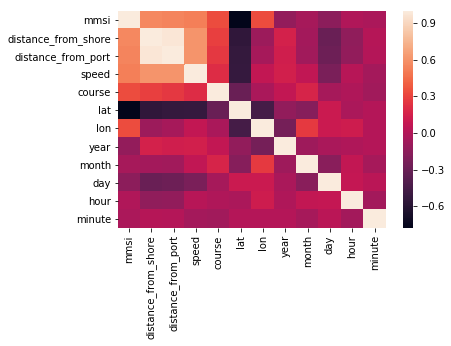

In [6]:
# Examine possible correlations between features
corr = X_train.corr()
sns.heatmap(corr)
corr[['distance_from_shore', 'distance_from_port']]


In [7]:
# Remove 'distance_from_shore' from training set since it is higly correlated with 'distance_from_port'
X_train = X_train.drop('distance_from_shore', axis=1)
X_test = X_test.drop('distance_from_shore', axis=1)

### Train models

In [8]:
# Normalize features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train) 
X_test_std = sc.transform(X_test)

# Logistic regression (optimization needed for regularization parameter C)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
model_1 = LogisticRegression(C=1000.0, random_state=31).fit(X_train_std, y_train)
m1_y_pred = model_1.predict(X_test)
acc_m1 = model_1.score(X_test, y_test)
m1_roc_score = roc_auc_score(y_test, m1_y_pred)
m1_f1 = f1_score(y_test, m1_y_pred, average='micro')
print("Logistic regression:") 
print("Accuracy:", "{:.0%}".format(acc_m1))
print("AUC-ROC score:", m1_roc_score)
print("\n")

# Linear discriminant analysis (LDA)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model_4 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X_train_std, y_train)
m4_y_pred = model_4.predict(X_test)
acc_m4 = model_4.score(X_test, y_test)
m4_roc_score = roc_auc_score(y_test, m4_y_pred)
m4_f1 = f1_score(y_test, m4_y_pred, average='micro')
print("LDA:") 
print("Accuracy:", "{:.0%}".format(acc_m4))
print("AUC-ROC score:", m4_roc_score)
print("\n")

# SVM
from sklearn.svm import LinearSVC
model_2 = LinearSVC(random_state=31, tol=1e-5).fit(X_train_std, y_train)
m2_y_pred = model_2.predict(X_test)
acc_m2 = model_2.score(X_test, y_test)
m2_roc_score = roc_auc_score(y_test, m2_y_pred)
m2_f1 = f1_score(y_test, m2_y_pred, average='micro')
print("SVM:") 
print("Accuracy:", "{:.0%}".format(acc_m2))
print("AUC-ROC score:", m2_roc_score)
print("\n")

# Decision Tree (without any purning...likely prone to over-fitting)
from sklearn import tree
model_3 = tree.DecisionTreeClassifier().fit(X_train_std, y_train)
m3_y_pred = model_3.predict(X_test)
acc_m3 = model_3.score(X_test, y_test)
m3_roc_score = roc_auc_score(y_test, m3_y_pred)
m3_f1 = f1_score(y_test, m3_y_pred, average='micro')
print("Decision tree:") 
print("Accuracy:", "{:.0%}".format(acc_m3))
print("AUC-ROC score:", m3_roc_score)


Logistic regression:
Accuracy: 93%
AUC-ROC score: 0.5


LDA:
Accuracy: 93%
AUC-ROC score: 0.5




/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM:
Accuracy: 93%
AUC-ROC score: 0.5


Decision tree:
Accuracy: 41%
AUC-ROC score: 0.614171546565925


In [9]:
# Display true/neg positives and negatives
from sklearn.metrics import confusion_matrix

conf_matrix_list = []

# Logistic regression model 
[tn, fp], [fn, tp] = confusion_matrix(y_test, m1_y_pred, labels=[0, 1])
conf_matrix_list.append(np.array([tn, fp, fn, tp]))

# SVM model 
[tn, fp], [fn, tp] = confusion_matrix(y_test, m2_y_pred, labels=[0, 1])
conf_matrix_list.append(np.array([tn, fp, fn, tp]))

# Decision tree model 
[tn, fp], [fn, tp] = confusion_matrix(y_test, m3_y_pred, labels=[0, 1])
conf_matrix_list.append(np.array([tn, fp, fn, tp]))

# LDA model 
[tn, fp], [fn, tp] = confusion_matrix(y_test, m4_y_pred, labels=[0, 1])
conf_matrix_list.append(np.array([tn, fp, fn, tp]))

confusion_matrix = {' ': ['TN', 'FP', 'FN', 'TP'],
                    'Logistic Regression': conf_matrix_list[0],
                    'LDA': conf_matrix_list[3],
                    'SVM': conf_matrix_list[1],
                    'Decision tree': conf_matrix_list[2]}
confusion_matrix_df = pd.DataFrame(confusion_matrix)
confusion_matrix_df

,,Logistic Regression,LDA,SVM,Decision tree
0,TN,80349,80349,80349,29864
1,FP,0,0,0,50485
2,FN,6272,6272,6272,899
3,TP,0,0,0,5373


In [10]:
# Which features were most important (by coefficients) for each model? 
m1_feat_importance = model_1.coef_
m2_feat_importance = model_2.coef_
m3_feat_importance = pd.Series(model_3.feature_importances_, index=X_train.columns)
m4_feat_importance = model_4.coef_
# m4_feat_importance = pd.Series(model_4.feature_importances_, index=X_train.columns)

features = ['mmsi', 'distance_from_port', 'speed', 'course', 'lat', 'lon', 'year', 'month', 'day', 'hour', 'minute']
feat_importance_all = {'Feature': ['mmsi', 'distance_from_port', 'speed', 'course', 'lat', 'lon', 'year', 'month', 'day', 'hour', 'minute'],
                       'Logit':  m1_feat_importance[0],
                       'SVM':  m2_feat_importance[0],
                       'DTree':  m3_feat_importance,
                       'LDA':  m4_feat_importance[0]}

feat_importance_all = pd.DataFrame(feat_importance_all, columns = ['Feature','Logit','SVM','DTree','LDA'])
feat_importance_all = feat_importance_all.drop('Feature', axis=1)
print("Coefficents for each feature:")
feat_importance_all

Coefficents for each feature:


,Logit,SVM,DTree,LDA
mmsi,-0.731413,-0.152097,0.002485,-0.647949
distance_from_port,1.356188,0.298420,0.091932,1.460396
speed,-0.972345,-0.211574,0.255669,-1.011471
course,-0.473448,-0.109580,0.057541,-0.701417
lat,0.062263,-0.023690,0.317832,-0.377927
lon,-0.345834,-0.085858,0.183278,-0.284240
year,-0.650161,-0.143678,0.001180,-0.733434
month,-0.424297,-0.083509,0.008080,-0.246904
day,-0.242631,-0.036400,0.074392,-0.122338
hour,-0.027471,-0.003783,0.004819,-0.018977


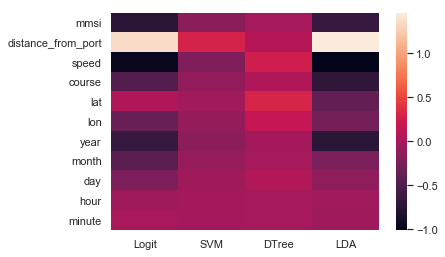

In [11]:
# Display feature coefficent scores as a heatmap
import seaborn as sns; sns.set()
ax = sns.heatmap(feat_importance_all)

### Feature generation 

In reviewing of how longlines operate (see Information sources below), there are features that can be generated from our data set. I have currently generated the following two features:

 - number of times the vessel changed directions
 - proximity to other vessels of fishing status active: "Fleet fishing is probably one of the best ways to find fish. Five or six boats searching for fish are much more effective than one boat" (Beverly et. al, 2003)


The following are additional features that could be useful and added for future modeling:
 - proximity to other vessels of fishing status inactive, moving faster than XX
 - proximity to other vessels of fishing status inactive, moving slower than XX
 - length of time away from shore (deep ocean)
 - day number wrt day 0 == jan 12012
 - sea surface temperature (SST): SST is used to locate fronts – rapid rises or falls in temperature – which is where fish tend to aggregate. SST is one of the more important parameters the longline fisherment use. NOAA has this historic data available for the relevant years ([data](https://www.ncei.noaa.gov/data/sea-surface-temperature-whoi/access/))
 - sea bed topography: "Seamounts, ridges, and isobath curves (a line on a chart connecting places with the same depth — also called bottom contours) are often targeted by longliners. Seamounts are identified on a chart as a cluster of concentric isobaths, with the shallowest ones in the centre." (Beverly et. al, 2003)
 - current charts
 - temperature breaks

**Information sources**:
 - Beverly et. al, 2003 [paper](https://coastfish.spc.int/Sections/Development/FDSPublications/FDSManuals/HLL/HLL.pdf)) 
 - Food and Agriculture Organization of the United Nations [website](http://www.fao.org/fishery/fishtech/1010/en)
 

In [12]:
# Feature generation: Number of times the vessel changed directions

temp_df = longline.groupby(['mmsi', 'year', 'month', 'day','hour']).nunique()
temp_df.rename(columns={'course': 'change_course'}, inplace=True)
temp_df.drop(['mmsi','distance_from_shore', 'distance_from_port', 'speed', 'lat','lon', 'is_fishing', 'year', 'month', 'day', 'hour', 'minute'], axis=1, inplace=True)
temp_df.reset_index(inplace=True)

# Add feature to data set
longline_2 = pd.merge(longline, temp_df, how='left', on=['mmsi', 'year', 'month', 'day','hour'])
longline_2.head(10)

,mmsi,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,year,month,day,hour,minute,change_course
0,12639600000000,232994.2813,311748.6563,8.2,230.500000,14.865583,-26.853662,-1,2012,1,21,9,1,3
1,12639600000000,232994.2813,311748.6563,8.2,230.500000,14.865583,-26.853662,-1,2012,1,21,9,1,3
2,12639600000000,233994.2656,312410.3438,7.3,238.399994,14.863870,-26.856800,-1,2012,1,21,9,3,3
3,12639600000000,233994.2656,312410.3438,7.3,238.399994,14.863870,-26.856800,-1,2012,1,21,9,3,3
4,12639600000000,233994.2656,312410.3438,6.8,238.899994,14.861551,-26.860649,-1,2012,1,21,9,5,3
5,12639600000000,233994.2656,312410.3438,6.8,238.899994,14.861551,-26.860649,-1,2012,1,21,9,5,3
6,12639600000000,233994.2656,315417.3750,6.9,251.800003,14.822686,-26.865898,-1,2012,1,21,10,54,3
7,12639600000000,233994.2656,315417.3750,6.9,251.800003,14.822686,-26.865898,-1,2012,1,21,10,54,3
8,12639600000000,233996.3906,316172.5625,6.1,231.100006,14.821825,-26.867579,-1,2012,1,21,10,55,3
9,12639600000000,233996.3906,316172.5625,6.1,231.100006,14.821825,-26.867579,-1,2012,1,21,10,55,3


In [ ]:
# Feature generation: Proximity to other vessels of fishing status active or inactive

# Note: This code does not work but was included as awork in progress.

# Create training data
train_2 = longline_2[longline_2['is_fishing'] != -1]

index_list, fishing_nearby_list = [],[]
fishing_nearby_status = 0
count = 1

# Calculate distance between two GPS coordinates
from sklearn.neighbors import DistanceMetric
hs = DistanceMetric.get_metric("haversine")

for index1, row1 in train.iterrows():
    for index2, row2 in train.iterrows():
        
        # skip for same vessel
        if row1['mmsi'] == row2['mmsi']:
            continue

        # for different vessels
        else:
            # for vessels within 1000 km on same day, record nearby vessel's fishing status
            if (row1['year'] == row2['year']) and (row1['month'] == row2['month']) and (row1['day'] == row2['day']):
                x_lat = (row1['lat'] * math.pi)/180
                x_lon = (row1['lon'] * math.pi)/180
                y_lat = (row2['lat'] * math.pi)/180
                y_lon = (row2['lon'] * math.pi)/180
                distance_matrix = (hs.pairwise([[x_lat, x_lon], [y_lat, y_lon]])*6371) # Earth radius in km
                distance = distance_matrix[0][1]

                if distance < 1000:
                    if row2['is_fishing'] != -1:
                        fishing_nearby_status += row2['is_fishing']
                        count += 1
                else:
                    continue
    
    # Record average score of nearby fishing status     
    index_list.append(index1)
    fishing_nearby_list.append(fishing_nearby_status/count)
    
#     # Print out results to monitor status
#     print(index1, row1['mmsi'], fishing_nearby_status, count)    

In [ ]:
# Save nearby_fishing feature cvs
nearby_fishing = pd.DataFrame(fishing_nearby_list, index = index_list, columns =['nearby_fishing']) 
nearby_fishing.to_csv(r'nearby_fishing_status.csv', index = False) # save to current directory


**End of analysis**. Next steps would be to retrain the models with these generated features.